# Introduction to Bayesian Optimization

*February 2017*

**Michiel Stock**

michielfmstock@gmail.com

In [61]:
import numpy as np
import sympy as sp
sp.init_printing()
from numpy import sin, exp, cos
from sklearn.preprocessing import normalize
from scipy.stats import norm
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
%matplotlib inline

In [62]:
def damped_oscillator(t_vals, m=1, g=2, k=17, sigma=0, x0=1):
    if g**2 > 4*k*m:
        l1 = (-g**2 + (g**2 - 4*k*m)**0.5) / (2 * m)
        l2 = (-g**2 - (g**2 - 4*k*m)**0.5) / (2 * m)
        c1, c2 = np.linalg.solve([[1, 1], [l1, l2]], [[x0], [0]]).flatten()
        y_vals = c1 * exp(t_vals * l1) + c2 * exp(t_vals * l2)
    elif g**2 == 4*k*m:
        l1 = - g / (2 * m)
        c1, c2 = np.linalg.solve([[1, 0], [l1, 1]], [[x0], [0]]).flatten()
        y_vals = c1 * exp(t_vals * l1) + c2 * t_vals * exp(t_vals * l1)
    else:
        alpha = - g / (2 * m)
        beta = (4 * m * k - g**2)**0.5 / (2 * m)
        c1, c2 = np.linalg.solve([[1, 0], [alpha, beta]], [[x0], [0]]).flatten()
        y_vals = exp(alpha * t_vals) * (c1 * cos(beta * t_vals) + c2 * sin(beta * t_vals))
    return y_vals + np.random.randn(len(t_vals)) * sigma

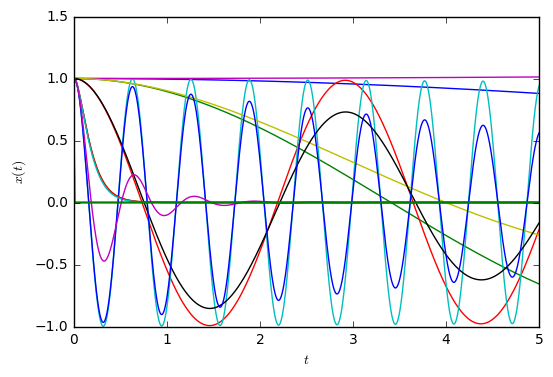

In [63]:
fig, ax = plt.subplots()

t_vals = np.linspace(0, 5, num = 1000)

for g in np.logspace(-2, 2, num=4):
    for k in np.logspace(-2, 2, num=4):
        y_vals = damped_oscillator(t_vals, g=g, k=k)
        ax.plot(t_vals, y_vals)
ax.set_xlabel('$t$')
ax.set_ylabel('$x(t)$')

In [64]:
# parameters
m=1
kstar=16
gstar=0.3

In [65]:
# noisy observations
t_meas = np.linspace(0, 5, num=20)
y_obs = damped_oscillator(t_meas, g=gstar, k=kstar, m=m, sigma=0.2)

In [66]:
# true function
t_vals = np.linspace(0, 5, num = 1000)
y_vals = damped_oscillator(t_vals, g=gstar, k=kstar, m=m)

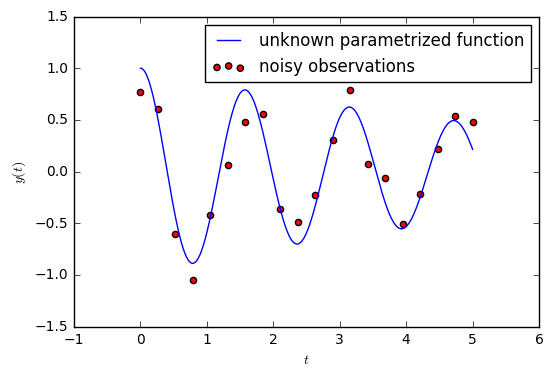

In [67]:
fig, ax = plt.subplots()

ax.plot(t_vals, y_vals, label='unknown parametrized function')
ax.scatter(t_meas, y_obs, c='r', label='noisy observations')
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
ax.legend(loc=0)

In [68]:
def get_mse(g, k):
    """
    Computes the mean squared error for a given gamma and k
    """
    y_sim = damped_oscillator(t_meas, g=g, k=k)
    return np.mean((y_sim - y_obs)**2)

In [69]:
g_vals = np.logspace(-2, 2, num=100)
k_vals = np.logspace(-2, 2, num=100)

mse_pars = np.zeros((len(g_vals), len(k_vals)))
for i, g in enumerate(g_vals):
    for j, k in enumerate(k_vals):
        mse_pars[i, j] = get_mse(g=g, k=k)

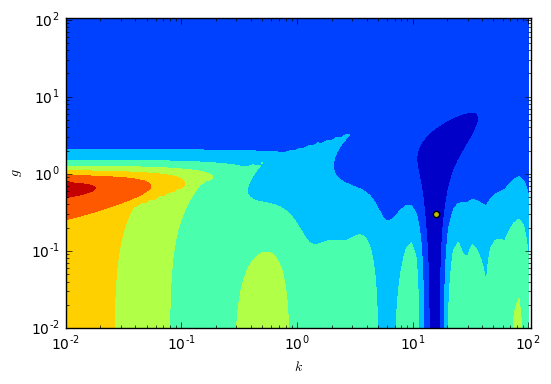

In [70]:
G, K = np.meshgrid(g_vals, k_vals)

fig, ax = plt.subplots()
ax.contourf(K, G, mse_pars.T)
ax.set_xlabel('$k$')
ax.set_ylabel('$g$')
ax.scatter(kstar, gstar, c='y')
ax.loglog()

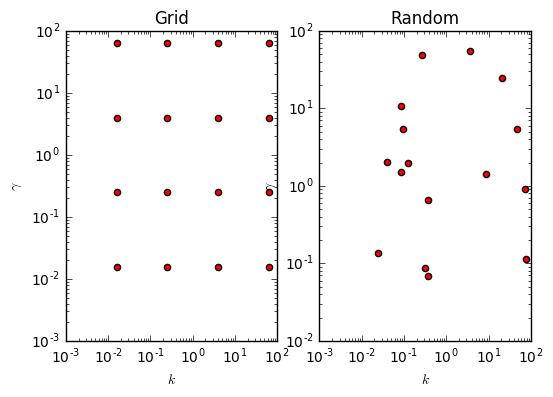

In [87]:
param_grid = np.array([[g, k] for k in np.logspace(-1.8, 1.8, num=4) for g in np.logspace(-1.8, 1.8, num=4)])
param_random = 10**(np.random.uniform(-2, 2, size=(16, 2)))

fig, (ax0, ax1) = plt.subplots(ncols=2)

ax0.scatter(param_grid[:,0], param_grid[:,1], c='r')
ax0.set_title('Grid')

ax1.scatter(param_random[:,0], param_random[:,1], c='r')
ax1.set_title('Random')

for ax in (ax1, ax0):
    ax.loglog()
    ax.set_xlabel('$k$')
    ax.set_ylabel('$\gamma$')

In [88]:
simulated_parameters = param_random
mse_obs = np.array([get_mse(g, k) for g, k in simulated_parameters])
mse_obs

array([ 1.05955389,  1.08196653,  0.224316  ,  0.23169462,  0.75198503,
        0.65468762,  0.22418581,  0.23169462,  0.74188208,  0.52098088,
        0.37364084,  0.23169462,  0.71765165,  0.52831434,  0.24729216,
        0.23169462])

In [89]:
gaussian_process = GaussianProcessRegressor()
gaussian_process.fit(np.log10(simulated_parameters), mse_obs)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [90]:
instance = np.log10([[3, 0.1]])

print(gaussian_process.predict(instance, return_std=True))

(array([ 0.24906533]), array([ 0.18031651]))


In [91]:
mu_mse = np.zeros_like(mse_pars)
std_mse = np.zeros_like(mse_pars)

for i, g in enumerate(g_vals):
    for j, k in enumerate(k_vals):
        instance = np.log10([[g, k]])
        mu, sigma = gaussian_process.predict(instance, return_std=True)
        mu_mse[i, j] = mu[:]
        std_mse[i, j] = sigma[:]

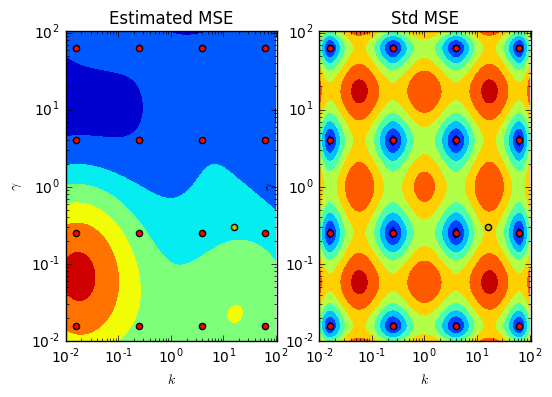

In [92]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.contourf(K, G, mu_mse.T)
ax0.set_title('Estimated MSE')

ax1.contourf(K, G, std_mse.T)
ax1.set_title('Std MSE')

for ax in (ax0, ax1):
    ax.set_xlabel('$k$')
    ax.set_ylabel('$\gamma$')
    ax.loglog()
    ax.scatter(kstar, gstar, c='y')
    ax.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c='r')

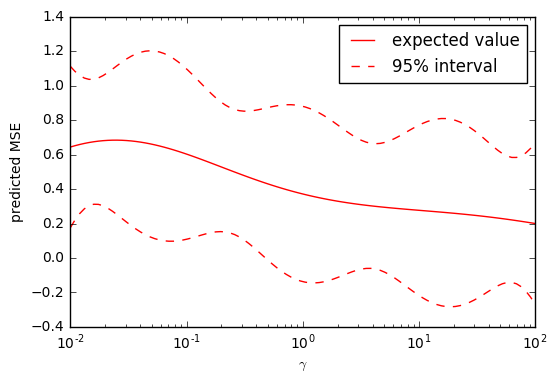

In [93]:
k_slice = np.column_stack((np.logspace(-2, 2, num=100), [1]*100))
# expected mse, std
mu, sigma = gaussian_process.predict(np.log10(k_slice), return_std=True)

fig, ax = plt.subplots()
ax.plot(k_slice[:,0], mu, c='r', label='expected value')
ax.plot(k_slice[:,0], mu-2*sigma, c='r', ls='--', label='95% interval')
ax.plot(k_slice[:,0], mu+2*sigma, c='r', ls='--')
ax.semilogx()
ax.set_xlabel('$\gamma$')
ax.set_ylabel('predicted MSE')
ax.legend(loc=0)

**Probability of Improvement**

$$
a_\text{PI}(\mathbf{x}) = P(f(\mathbf{x})<f(\mathbf{x}_\text{best}) ) = \Phi(\gamma(\mathbf{x}))\,,
$$
with $\Phi(\cdot)$ the CDF of a standard normal distirbution and 
$$
\gamma(\mathbf{x})= \frac{f(x_\text{best}) - \mu(\mathbf{x})}{\sigma(\mathbf{x})}\,.
$$

In [94]:
def calculate_gamma(mu, sigma, fbest):
    return (fbest - mu) / sigma

def probability_improvement(mu, sigma, fbest=np.min(mse_obs)):
    """
    Calculates probability of improvement
    """
    gamma_values = calculate_gamma(mu, sigma, fbest)
    return norm.cdf(gamma_values)

**Expected Improvement**

$$
a_\text{EI}(\mathbf{x}) = E[f(\mathbf{x}) - f(\mathbf{x}_\text{best})] = \sigma(\mathbf{x})(\gamma(\mathbf{x})\Phi(\gamma(\mathbf{x})) + \phi(\gamma(\mathbf{x}))\,,
$$
with $\phi(\cdot)$ the PDF of a standard normal distirbution.

In [95]:
def expected_improvement(mu, sigma, fbest=np.min(mse_obs)):
    """
    Calculates expected improvement
    """
    gamma_values = calculate_gamma(mu, sigma, fbest)
    return sigma * (gamma_values * norm.cdf(gamma_values) + norm.pdf(gamma_values))

**GP Upper Confidence Limit**

$$
a_\text{UCB} = \mu(\mathbf{x}) + \kappa \sigma(\mathbf{x})\,,
$$
with $\kappa$ a parameter determining the tightness of the bound.

In [96]:
def upper_confidence_bound(mu, sigma, kappa=2):
    """
    Calculates lower confidence bound
    """
    return mu + kappa * sigma

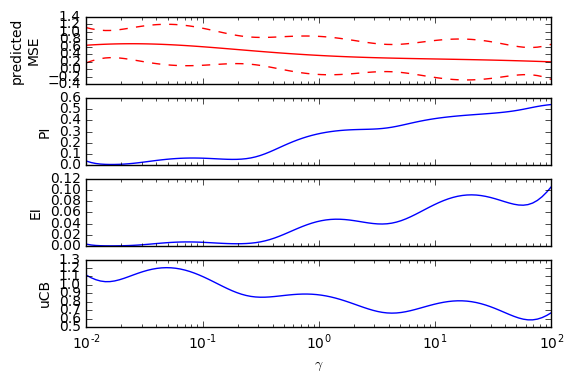

In [97]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, sharex=True)

# plot mu and sigma
ax0.plot(k_slice[:,0], mu, c='r', label='expected value')
ax0.plot(k_slice[:,0], mu-2*sigma, c='r', ls='--', label='95% interval')
ax0.plot(k_slice[:,0], mu+2*sigma, c='r', ls='--')
ax0.semilogx()
ax0.set_ylabel('predicted\nMSE')

# plot information gains
ax1.plot(k_slice[:,0], probability_improvement(mu, sigma), label='PI')
ax1.set_ylabel('PI')
ax2.plot(k_slice[:,0], expected_improvement(mu, sigma), label='EI')
ax2.set_ylabel('EI')
ax3.plot(k_slice[:,0], upper_confidence_bound(mu, sigma), label='LCB')
ax3.set_ylabel('uCB')
ax3.set_xlabel('$\gamma$')


In [98]:
PI = np.zeros_like(mse_pars)
EI = np.zeros_like(mse_pars)
UCB = np.zeros_like(mse_pars)

for i, g in enumerate(g_vals):
    for j, k in enumerate(k_vals):
        instance = np.log10([[g, k]])
        mu, sigma = gaussian_process.predict(instance, return_std=True)
        mu = mu[:]
        sigma = sigma[:]
        PI[i,j] = probability_improvement(mu, sigma)
        EI[i,j] = expected_improvement(mu, sigma)
        UCB[i,j] = upper_confidence_bound(mu, sigma)

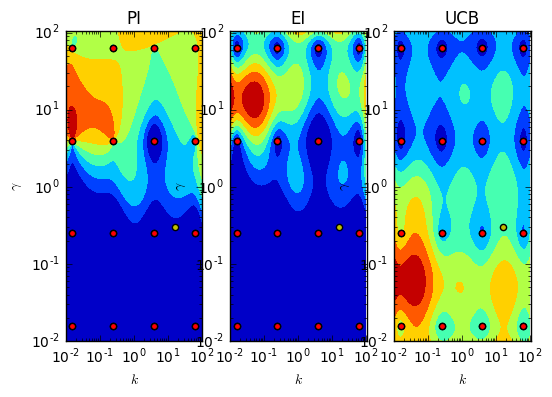

In [99]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
ax0.contourf(K, G, PI.T)
ax0.set_title('PI')
ax0.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c='r')

ax1.contourf(K, G, EI.T)
ax1.set_title('EI')
ax1.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c='r')

ax2.contourf(K, G, UCB.T)
ax2.set_title('UCB')
ax2.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c='r')

for ax in (ax0, ax1, ax2):
    ax.set_xlabel('$k$')
    ax.set_ylabel('$\gamma$')
    ax.loglog()
    ax.scatter(kstar, gstar, c='y')
    ax.scatter(simulated_parameters[:,0], simulated_parameters[:,1], c='r')